---
author: Mauricio Alejandro Prieto Palacios
title: Fitness class attendance prediction
categories: [news, code, analysis]
image: "club.jpeg"
format:
    html:
        theme: pulse
        toc: true
        code-fold: true
        code-tools: true 
        highlight-style: arrow
        toc-title: Contents
        anchor-sections: true
        link-external-icon: true
        code-block-bg: false
        code-block-border-left: "#10A19D" 
        embed-resources: true
        fig-align: center
        
---

::: {.callout-note}
The repository of the project is [here](https://github.com/alejandro77palacios/fitness).
:::

## Background

I'm working for a fitness club chain. It offers a range of fitness classes in two capacities – 25 and 15.

Here is the problem. The club has noticed that some of their classes are always fully booked. But fully booked classes often have a low attendance rate. 

The fitness club wants to increase the number of spaces available for classes, so that new members can join. To achieve this, they need to predict whether a member will attend the class or not. If they perform this accurately, they can make another space available.

### Dataset
The dataset contains each record when a member registered for a fitness class. The data includes the following fields:

- booking_id (nominal). The unique identifier of the booking.
- months_as_member (discrete). The number of months as member, minimum 1 month.
- weight (continuous). The member's weight in kg, rounded to two decimal places. The minimum possible value is 40.00 kg.
- days_before (discrete). The number of days before the class the member registered, minimum 1 day.
- day_of_week (ordinal). The day of the class.
- time (ordinal). The time of day of the class. Either “AM” or “PM”.
- category (nominal). The category of the fitness class. One of “Yoga”, “Aqua”, “Strength”, “HIIT”, or “Cycling”.
- attended (nominal). Whether the member attended the class (1) or not (0).

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [2]:
my_palette = ['#10A19D', '#540375', '#FF7000', '#FFBF00', '#dd44aa', '#BEBEBE', '#112385']
sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(my_palette))

In [3]:
fitness = pd.read_csv('data/fitness_class_2212.csv')
fitness

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0
...,...,...,...,...,...,...,...,...
1495,1496,21,79.51,10,Fri,AM,HIIT,0
1496,1497,29,89.55,2,Mon,AM,Strength,0
1497,1498,9,87.38,4,Tue,AM,HIIT,0
1498,1499,34,68.64,14,Sun,AM,Aqua,0


## Reading data
The dataset is stored in a csv file.

In [4]:
fitness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1480 non-null   float64
 3   days_before       1500 non-null   object 
 4   day_of_week       1500 non-null   object 
 5   time              1500 non-null   object 
 6   category          1500 non-null   object 
 7   attended          1500 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 93.9+ KB


The only missing values are in the column `weight`. So, there is no need to impute any other column.

### Auxiliary functions
To simplify the code, I will define some auxiliary functions.

In [5]:
def show_unique(column):
    if column not in fitness.columns:
        raise ValueError(f'Column {column} not in dataframe {fitness}')
    return fitness[column].drop_duplicates().sort_values().reset_index(drop=True)

In [6]:
def show_sensitivity(conf_mat):
    senstivity = conf_mat[1, 1] / (conf_mat[1, 0] + conf_mat[1, 1])
    print(f'Sensitivity: {senstivity}')

In [7]:
def show_specificity(conf_mat):
    specificity = conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[0, 1])
    print(f'Specificity: {specificity}')

In [8]:

def show_roc_score(estimator, X_test, y_test):
    y_pred = estimator.predict_proba(X_test)[:, 1]
    print(f'ROC AUC score: {roc_auc_score(y_test, y_pred)}')

In [9]:
plot_name = {
    'booking_id': 'Booking ID',
    'months_as_member': 'Months as member',
    'weight': 'Weight',
    'days_before': 'Days before',
    'day_of_week': 'Day of week',
    'time': 'Time',
    'category': 'Category',
    'attended': 'Attended'
}

## Data validation
I will check every variable in its own subsection. In general, there are few erros and the cleaning process is straightforward.

### `booking_id`
There is no duplicates, and the values are unique. Also, the values are integers (even though the method `describe` transforms then into float).

In [10]:
fitness['booking_id'].describe()

count    1500.000000
mean      750.500000
std       433.157015
min         1.000000
25%       375.750000
50%       750.500000
75%      1125.250000
max      1500.000000
Name: booking_id, dtype: float64

In [11]:
fitness['booking_id'].duplicated().any()

False

### `months_as_member`
As mentioned above, there are no missing values, so it is not necessary to impute. The minimum value is 1 as expected.

In [12]:
fitness['months_as_member'].describe()

count    1500.000000
mean       15.628667
std        12.926543
min         1.000000
25%         8.000000
50%        12.000000
75%        19.000000
max       148.000000
Name: months_as_member, dtype: float64

In [13]:
assert fitness['months_as_member'].min() >= 1

### `weight`
There are missing values, so I will impute them with the mean. The minimum value is 40 as expected.

In [14]:
fitness['weight'].describe()

count    1480.000000
mean       82.610378
std        12.765859
min        55.410000
25%        73.490000
50%        80.760000
75%        89.520000
max       170.520000
Name: weight, dtype: float64

In [15]:
assert fitness['weight'].min() >= 40.0

In [16]:
fitness['weight'].isna().sum()

20

In [17]:
fitness['weight'].fillna(fitness['weight'].mean(), inplace=True)

In [18]:
assert fitness['weight'].isna().sum() == 0

### `days_before`
It is a discrete variable, but there is a problem with the values. Some of them ends with string `days`. Also, there are some values with spaces at the beginning. I will remove the string `days` as well as the spaces. The minimum value is 1, which makes sense.

In [19]:
show_unique('days_before')

0           1
1      1 days
2          10
3     10 days
4          11
5          12
6     12 days
7          13
8     13 days
9          14
10    14 days
11         15
12         16
13         17
14          2
15     2 days
16         20
17         29
18          3
19     3 days
20          4
21     4 days
22          5
23     5 days
24          6
25     6 days
26          7
27     7 days
28          8
29     8 days
30          9
Name: days_before, dtype: object

In [20]:
fitness['days_before'] = (
    fitness['days_before']
    .str.replace(r'\s*days', '', regex=True)
    .str.strip()
    .astype(int)
)
show_unique('days_before')

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    20
18    29
Name: days_before, dtype: int64

In [21]:
assert fitness['days_before'].min() >= 1

### `day_of_week`
There are some misspellings. Since they are just three, a mapping is the simplest idea. I'll also add the natural order of the days.

In [22]:
show_unique('day_of_week')

0          Fri
1         Fri.
2          Mon
3       Monday
4          Sat
5          Sun
6          Thu
7          Tue
8          Wed
9    Wednesday
Name: day_of_week, dtype: object

In [23]:
day_map = {
    'Fri.': 'Fri',
    'Monday': 'Mon',
    'Wednesday': 'Wed'
}

In [24]:
fitness['day_of_week'] = fitness['day_of_week'].replace(day_map)
show_unique('day_of_week')

0    Fri
1    Mon
2    Sat
3    Sun
4    Thu
5    Tue
6    Wed
Name: day_of_week, dtype: object

In [25]:
fitness['day_of_week'] = (
    fitness['day_of_week']
    .astype('category')
    .cat.set_categories(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    .cat.as_ordered()
)
show_unique('day_of_week')

0    Mon
1    Tue
2    Wed
3    Thu
4    Fri
5    Sat
6    Sun
Name: day_of_week, dtype: category
Categories (7, object): ['Mon' < 'Tue' < 'Wed' < 'Thu' < 'Fri' < 'Sat' < 'Sun']

### `time`
There are not errors, but I'll add the order of time.

In [26]:
show_unique('time')

0    AM
1    PM
Name: time, dtype: object

In [27]:
fitness['time'] = (
    fitness['time'].astype('category')
    .cat.set_categories(['AM', 'PM'])
    .cat.as_ordered()
)
show_unique('time')

0    AM
1    PM
Name: time, dtype: category
Categories (2, object): ['AM' < 'PM']

### `category`
There is an unknown category `'-'`, so I'll rename it as `'unknown'`.

In [28]:
show_unique('category')

0           -
1        Aqua
2     Cycling
3        HIIT
4    Strength
5        Yoga
Name: category, dtype: object

In [29]:
fitness['category'] = (
    fitness['category']
    .str.replace(r'-', 'unknown', regex=True)
    .astype('category')
    .cat.set_categories(['Yoga', 'Aqua', 'Strength', 'HIIT', 'Cycling', 'unknown'])
)
show_unique('category')

0        Yoga
1        Aqua
2    Strength
3        HIIT
4     Cycling
5     unknown
Name: category, dtype: category
Categories (6, object): ['Yoga', 'Aqua', 'Strength', 'HIIT', 'Cycling', 'unknown']

### `attended`
I prefer using the values `Yes` and `No` instead of `1` and `0` in the analysis. This will enhance readability in the following plots. For the modelling stage, I will use the original values.

In [30]:
show_unique('attended')

0    0
1    1
Name: attended, dtype: int64

In [31]:
fitness['attended'] = (
    fitness['attended']
    .replace({0: 'No', 1: 'Yes'})
    .astype('category')
    .cat.set_categories(['Yes', 'No'])
    .cat.as_ordered()
)
show_unique('attended')

0    Yes
1     No
Name: attended, dtype: category
Categories (2, object): ['Yes' < 'No']

### Summary
The original data has 1,500 rows and 8 columns. No line was removed, but some values were imputed

- `booking_id`: Values are unique as expected
- `months_as_member`: Values are integers, there were no missing values, and the minimum value was 1
- `weight`: There were 20 missing values that I imputed with the mean. The minimum value was 40.0 as expected
- `days_before`: Cleaned up text and converted to numeric, minimum value was 1 as expected. There were no missing values.
- `day_of_week`: Corrected misspellings, categories were “Mon”, “Tue”, “Wed”, “Thu”, “Fri”, “Sat” and “Sun” as expected. There were no missing values
- `time`: No problem, the categories are “AM” and “PM”. There were no missing values
- `category`: I replaced `'-'` with “unknown”. The other categories are “Yoga”, “Aqua”, “Strength”, “HIIT”, or “Cycling”, as expected
- `attended`: Values were 0 and 1 as expected, no missing values.

## Data analysis

### Target variable
The attendance is the target variable, so it's more important to visualise its behaviour. There is a clear imbalance:

[Text(0.5, 0, 'Attended'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Memers attendence')]

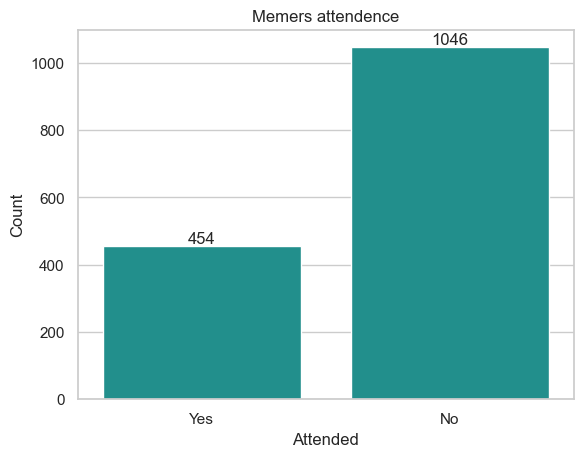

In [32]:
plot_attended = sns.countplot(data=fitness, x='attended')
plot_attended.bar_label(plot_attended.containers[0])
plot_attended.set(xlabel=plot_name['attended'], ylabel='Count', title='Memers attendence')

Some categories have a higher attendance than others.

[Text(0.5, 0, 'Count'),
 Text(0, 0.5, 'Category'),
 Text(0.5, 1.0, 'Category attendence')]

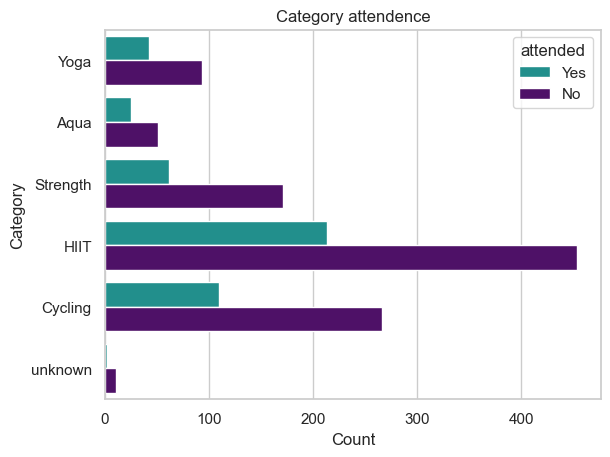

In [33]:
plot_category_attended = sns.countplot(data=fitness, y='category', hue='attended')
plot_category_attended.set(xlabel='Count', ylabel=plot_name['category'], title='Category attendence')

 In particular, HIIT has the lowest attendance, with more than 400 people. It is worth noting that there are always more members that don't attend than members that do it.

### Time as members
There are some outliers in the `months_as_member` variable. So a boxplot is a good option to visualize its distribution.

[Text(0.5, 0, 'Months as member'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of months as member')]

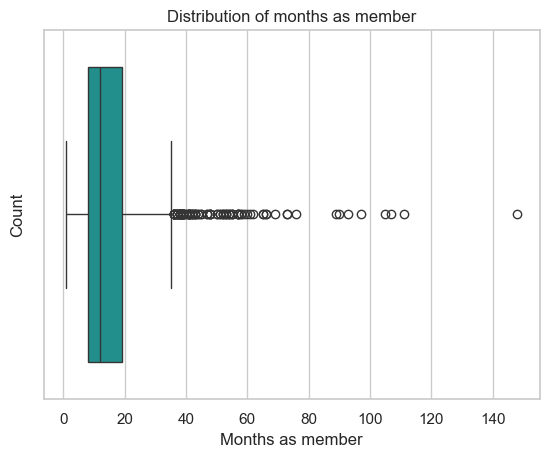

In [34]:
plot_months = sns.boxplot(data=fitness, x='months_as_member')
plot_months.set(xlabel=plot_name['months_as_member'], ylabel='Count', title='Distribution of months as member')

There are quite a few outliers, they correspond to long-term members. It's possible that they are the ones who attend the most. On the other hand, recent members have in general about 10 months in the club.

### Relationship between variables

[Text(0.5, 0, 'Months as member'),
 Text(0, 0.5, 'Attended'),
 Text(0.5, 1.0, 'Distribution of months as member by attendence')]

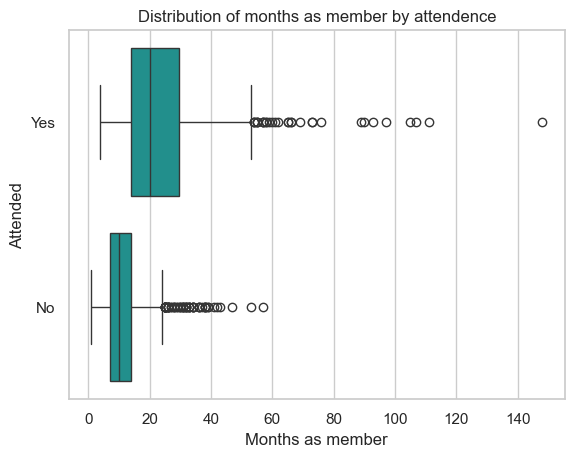

In [35]:
plot_months_attended = sns.boxplot(data=fitness, x='months_as_member', y='attended')
plot_months_attended.set(xlabel=plot_name['months_as_member'], ylabel=plot_name['attended'],
                         title='Distribution of months as member by attendence')

As expected, the long-term members are the ones who attend the most. There is a clear difference between the median of the two groups. This is a good indicator that the variable `months_as_member` is a good predictor of the attendance. Instead of performing a t-test, I will use it directly in the modelling stage.

[Text(0.5, 0, 'Months as member'),
 Text(0, 0.5, 'Weight'),
 Text(0.5, 1.0, 'Relation between months as member and weight')]

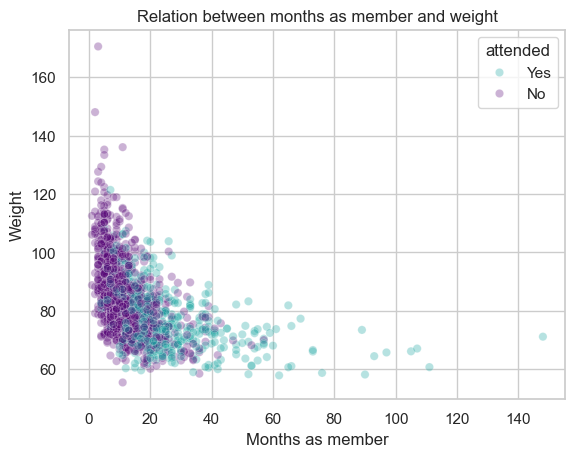

In [36]:
plot_weight_attended = sns.scatterplot(data=fitness, x='months_as_member', y='weight', hue='attended', alpha=0.3)
plot_weight_attended.set(xlabel=plot_name['months_as_member'], ylabel=plot_name['weight'],
                         title='Relation between months as member and weight')

People that attend more and has more months in the club tend to have a lower weight. This is a good indicator that the variable `weight` is a good predictor of the attendance. Poeple that has recently joined the club has a higher weight and usually don't attend.

[Text(0.5, 0, 'Days before'),
 Text(0, 0.5, 'Weight'),
 Text(0.5, 1.0, 'Relation between days before and weight')]

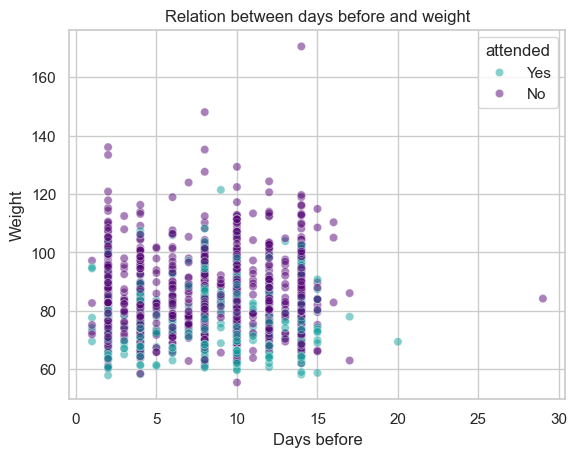

In [37]:
plot_days_weight = sns.scatterplot(data=fitness, x='days_before', y='weight', hue='attended', alpha=0.5)
plot_days_weight.set(xlabel=plot_name['days_before'], ylabel=plot_name['weight'],
                         title='Relation between days before and weight')

There is no clear relationship between the days before the registration and the attendance. However, the person who registered 30 days before didn't attend and the people who registered 1 day before attended. This variable might not be an important predictor, but it contains some information.

[Text(0.5, 0, 'Weight'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of weight by attendence')]

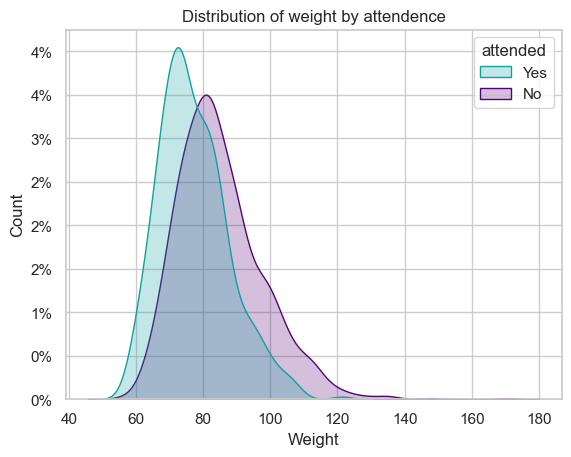

In [38]:
from matplotlib.ticker import FuncFormatter

plot_weight_attended = sns.kdeplot(data=fitness, x="weight", hue="attended", fill=True, common_norm=False)
plot_weight_attended.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot_weight_attended.set(xlabel=plot_name['weight'], ylabel='Count', title='Distribution of weight by attendence')

Although the distribution doesn't change much, the people with the lowest weight usually attend. 

[Text(0.5, 0, 'Weight'),
 Text(0, 0.5, 'Day of week'),
 Text(0.5, 1.0, 'Standard deviation of weight by day of week')]

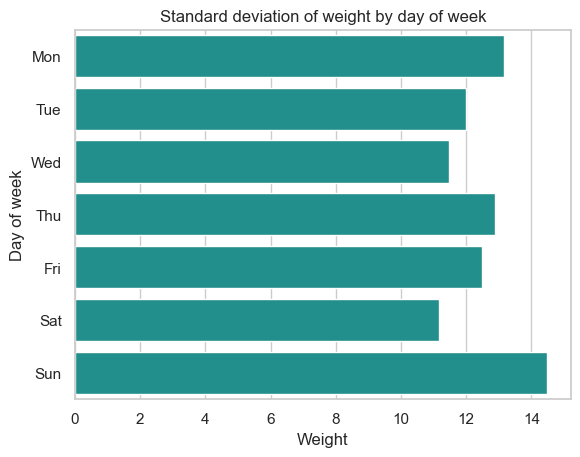

In [39]:
import numpy as np

plot_weight_days = sns.barplot(data=fitness, x='weight', y='day_of_week', estimator=np.std, errorbar=None)
plot_weight_days.set(xlabel=plot_name['weight'],
                     ylabel=plot_name['day_of_week'],
                     title='Standard deviation of weight by day of week'
                     )

Sunday is when the weight is more volatile, but the difference is not significant between the other days.

[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Days before'),
 Text(0.5, 1.0, 'Median of days before by time')]

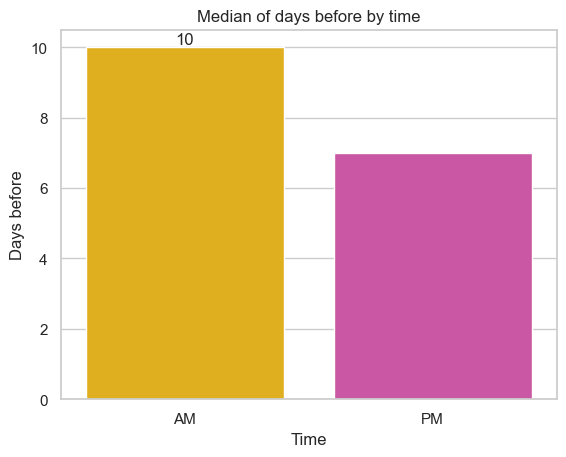

In [40]:
plot_before_time = sns.barplot(data=fitness,
                               x='time',
                               y='days_before',
                               estimator='median',
                               palette=sns.color_palette(my_palette[3:5]),
                               errorbar=None,
                               hue='time',
                               legend=False,
                               )
plot_before_time.bar_label(plot_before_time.containers[0])
plot_before_time.set(xlabel=plot_name['time'],
                     ylabel=plot_name['days_before'],
                     title='Median of days before by time')

The classes in the morning are usually booked with more days in advance than the classes in the afternoon. This is a good indicator that the variable `time` adds new information to the model.

## Data Modelling
Since we are trying to predict whether a member will attend the class or not, this is a classification problem. Before propose a model, I will preprocess the data for the task.
The main goal is to correctly predict attendance, so the metric is sensitivity. Nevertheless, I will also use the area under the ROC curve since the target is imbalanced.

### Preprocessing

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
features = fitness.drop(columns=['booking_id', 'attended'])
features

,months_as_member,weight,days_before,day_of_week,time,category
0,17,79.56,8,Wed,PM,Strength
1,10,79.01,2,Mon,AM,HIIT
2,16,74.53,14,Sun,AM,Strength
3,5,86.12,10,Fri,AM,Cycling
4,15,69.29,8,Thu,AM,HIIT
...,...,...,...,...,...,...
1495,21,79.51,10,Fri,AM,HIIT
1496,29,89.55,2,Mon,AM,Strength
1497,9,87.38,4,Tue,AM,HIIT
1498,34,68.64,14,Sun,AM,Aqua


In [43]:
features = pd.get_dummies(features, drop_first=True, dtype='int')
features

,months_as_member,weight,days_before,day_of_week_Tue,day_of_week_Wed,day_of_week_Thu,day_of_week_Fri,day_of_week_Sat,day_of_week_Sun,time_PM,category_Aqua,category_Strength,category_HIIT,category_Cycling,category_unknown
0,17,79.56,8,0,1,0,0,0,0,1,0,1,0,0,0
1,10,79.01,2,0,0,0,0,0,0,0,0,0,1,0,0
2,16,74.53,14,0,0,0,0,0,1,0,0,1,0,0,0
3,5,86.12,10,0,0,0,1,0,0,0,0,0,0,1,0
4,15,69.29,8,0,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,21,79.51,10,0,0,0,1,0,0,0,0,0,1,0,0
1496,29,89.55,2,0,0,0,0,0,0,0,0,1,0,0,0
1497,9,87.38,4,1,0,0,0,0,0,0,0,0,1,0,0
1498,34,68.64,14,0,0,0,0,0,1,0,1,0,0,0,0


In [44]:
target = fitness['attended'].replace({'Yes': 1, 'No': 0}).astype('int')
target

0       0
1       0
2       0
3       0
4       0
       ..
1495    0
1496    0
1497    0
1498    0
1499    1
Name: attended, Length: 1500, dtype: int64

In [45]:
seed = 1
X = features.values
y = target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
kf = KFold(n_splits=10, random_state=seed, shuffle=True)

### Baseline model
 The exploratory analysis revealed that the relationships between the target variable and the predictors were not linear. For this reason I decided to implement a flexible model like K-nearest neighbours. I will also use a 10-fold cross-validation to avoid overfitting.

In [46]:
param_grid = {'n_neighbors': range(1, 10)}
knearest = KNeighborsClassifier()
cv = GridSearchCV(knearest, param_grid, cv=kf, scoring='roc_auc')
cv.fit(X_train, y_train)
print(f'Best parameter: {cv.best_params_}')
print(f'Best score: {cv.best_score_:0.2f}')
best_knearest = cv.best_estimator_
predictions = best_knearest.predict(X_test)
confusion = confusion_matrix(y_test, predictions)
confusion

Best parameter: {'n_neighbors': 9}
Best score: 0.77


array([[270,  40],
       [ 72,  68]])

Sensitivity: 0.4857142857142857
Specificity: 0.8709677419354839
ROC AUC score: 0.7604377880184332


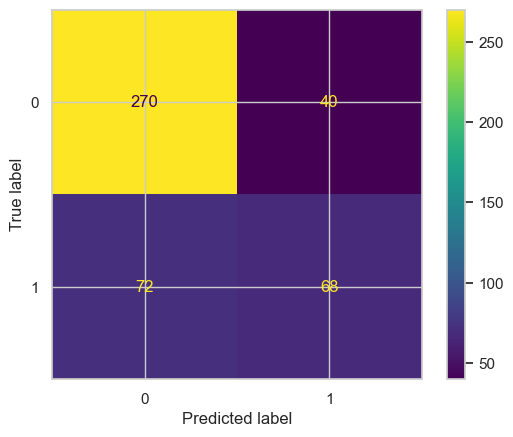

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels = best_knearest.classes_)
disp.plot()
show_sensitivity(confusion)
show_specificity(confusion)
show_roc_score(best_knearest, X_test, y_test)

To see the results, a confusion matrix is a good option.The main problem is that the model cannot correctly detect people that attend the class. Also, the best option seems to be 9 neighbours, which looks like a lot, reducing interpretability.

### Alternative model

The random forest model seems to me a good alternative since it allows eliminating correlations between the predictors, giving better interpretability and even analyzing the importance of the variables in a more in-depth analysis and in a non-technical presentation with the client.

In [48]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=seed, n_jobs=-1, min_samples_leaf=0.01)
param_grid = {'max_depth': [5, 20, 30],
              'n_estimators': [50, 100, 200, 300]}
cv = GridSearchCV(rf, param_grid, cv=kf, scoring='roc_auc')
cv.fit(X_train, y_train)
print(f'Best parameter: {cv.best_params_}')
print(f'Best score: {cv.best_score_}')

Best parameter: {'max_depth': 20, 'n_estimators': 200}
Best score: 0.8026098200988698


In [49]:
best_rf = cv.best_estimator_
predictions = best_rf.predict(X_test)
confusion = confusion_matrix(y_test, predictions)
confusion

array([[265,  45],
       [ 72,  68]])

In [50]:
senstivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
print(f'Sensitivity: {senstivity}')
print(f'Specificity: {specificity}')

Sensitivity: 0.4857142857142857
Specificity: 0.8548387096774194


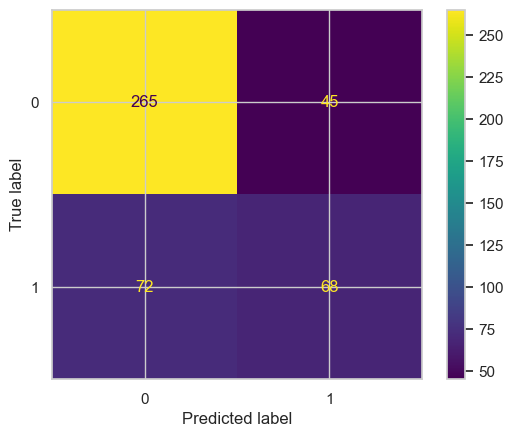

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels = best_rf.classes_)
disp.plot()

The results are quite similar. The main issue is sensitivity. Tunning hyperparameters didn't improve the results. 

### Results
Both models had problems detecting people who do attend classes (low sensitivity), which is evident in the fact that there are many false negatives (in fact, they exceed the true positives).

In contrast, they were able to correctly predict non-attendance (high specificity): in the context of the company this is the most important task. The two models had a high value of area under the roc curve, so in general their performance is good.

The models were tied in specificity, K-nearest neighbours gained in specificity, but random forests were better for the roc auc. I consider that the best model is k nearest neighbors since specificity is the most important metric for the company, it is considerably faster to train and its operation is easier to explain to decision makers.